# HANC with government and no capital

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Find stationary equilibrium](#toc2_)    
- 3. [Vary tax rate](#toc3_)    
- 4. [Transition path](#toc4_)    
  - 4.1. [Prepare](#toc4_1_)    
  - 4.2. [Find transition path](#toc4_2_)    
  - 4.3. [Analyze](#toc4_3_)    
- 5. [Extra: Optimal policy](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCGovModel import HANCGovModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCGovModelClass(name='baseline')

In [3]:
model.info(only_blocks=True)

government: [eta,G,pB] -> [tau,B]
hh: [pB,tau] -> [A_hh,C_hh,U_hh]
market_clearing: [B,A_hh] -> [clearing_B]


In [4]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Find stationary equilibrium](#toc0_)

Test household problem:

In [5]:
model.ss.tau = 0.12
model.ss.pB = 0.975

model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 6.2 secs [559 iterations]
household problem in ss simulated in 4.4 secs [657 iterations]


Find stationary equilibrium:

In [6]:
model.find_ss(tau=0.15,do_print=True)

### step 1: broad search ###

pB =   0.96500000

household problem in ss solved in 0.4 secs [708 iterations]
household problem in ss simulated in 0.7 secs [2643 iterations]
clearing_B =  -5.36216257

pB =   0.97000000

household problem in ss solved in 0.4 secs [667 iterations]
household problem in ss simulated in 0.2 secs [1104 iterations]
clearing_B =  -0.98953667

pB =   0.97500000

household problem in ss solved in 0.3 secs [561 iterations]
household problem in ss simulated in 0.1 secs [657 iterations]
clearing_B =   0.66038147

pB =   0.98000000

household problem in ss solved in 0.3 secs [471 iterations]
household problem in ss simulated in 0.1 secs [457 iterations]
clearing_B =   1.75267397

pB =   0.98500000

household problem in ss solved in 0.2 secs [400 iterations]
household problem in ss simulated in 0.0 secs [347 iterations]
clearing_B =   2.89362016

### step 2: determine search bracket ###

pB in [  0.97000000,  0.97500000]

### step 3: search ###

  0: pB =   0.97299874

Check goods market clearing:

In [7]:
assert np.isclose(ss.C_hh+ss.G,1.0)

## 3. <a id='toc3_'></a>[Vary tax rate](#toc0_)

Maximize average utility.

In [8]:
def target(tau):
    
    model.find_ss(tau)
    return -ss.U_hh

res = optimize.minimize_scalar(target,bounds=(0.11,0.2),method='bounded',options={'disp':3})
tau_max_U_hh = res.x
max_U_hh = res.fun

 
 Func-count     x          f(x)          Procedure
    1       0.144377      1.20697        initial
    2       0.165623      1.20871        golden
    3       0.131246      1.20652        golden
    4       0.125372      1.20655        parabolic
    5       0.129499      1.20651        parabolic
    6       0.129293      1.20651        parabolic
    7       0.129231      1.20651        parabolic
    8       0.129239      1.20651        parabolic
    9       0.129236      1.20651        parabolic
   10       0.129242      1.20651        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


Look at different tax rates.

In [9]:
taus = sorted([0.11,0.12,0.13,0.14,0.15]+[tau_max_U_hh])
B = np.zeros(len(taus))
pB = np.zeros(len(taus))
U_hh = np.zeros(len(taus))

for i,tau in enumerate(taus):
    
    model_ = model.copy()
    model_.find_ss(tau=tau,do_print=False)
    
    print(f'{model_.ss.pB = :8.3f}')
    print(f'{model_.ss.B = :8.3f}')
    print(f'{model_.ss.U_hh = :12.8f}\n')
    
    B[i] = model_.ss.B
    pB[i] = model_.ss.pB
    U_hh[i] = model_.ss.U_hh
    

model_.ss.pB =    0.983
model_.ss.B =    0.580
model_.ss.U_hh =  -1.20784652

model_.ss.pB =    0.978
model_.ss.B =    0.926
model_.ss.U_hh =  -1.20675420

model_.ss.pB =    0.976
model_.ss.B =    1.217
model_.ss.U_hh =  -1.20651229

model_.ss.pB =    0.976
model_.ss.B =    1.240
model_.ss.U_hh =  -1.20651370

model_.ss.pB =    0.974
model_.ss.B =    1.538
model_.ss.U_hh =  -1.20675613

model_.ss.pB =    0.973
model_.ss.B =    1.825
model_.ss.U_hh =  -1.20732825



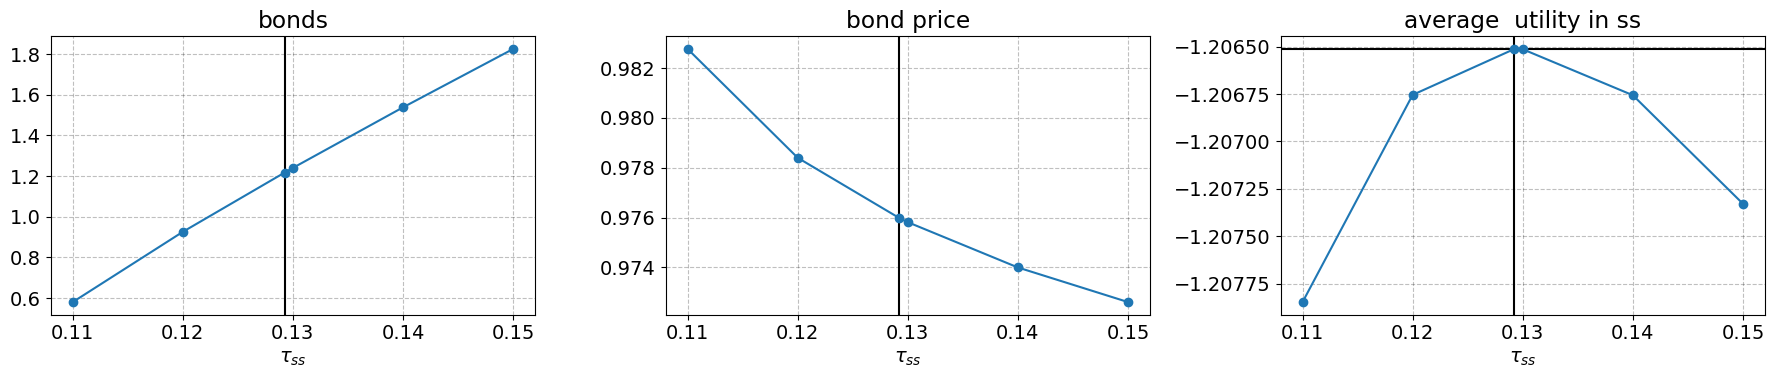

In [10]:
fig = plt.figure(figsize=(18,6/1.5),dpi=100)

ax = fig.add_subplot(1,3,1)
ax.set_title('bonds')
ax.axvline(tau_max_U_hh,color='black')
ax.plot(taus,B,'-o')
ax.set_xlabel('$\\tau_{ss}$')

ax = fig.add_subplot(1,3,2)
ax.set_title('bond price')
ax.axvline(tau_max_U_hh,color='black')
ax.plot(taus,pB,'-o')
ax.set_xlabel('$\\tau_{ss}$')

ax = fig.add_subplot(1,3,3)
ax.set_title('average  utility in ss')
ax.axvline(tau_max_U_hh,color='black')
ax.axhline(-max_U_hh,color='black')
ax.plot(taus,U_hh,'-o')
ax.set_xlabel('$\\tau_{ss}$')

fig.tight_layout()

**Insights:**

1. Bonds increasing in tax rate
2. Bond price decreasing in tax rate (higher return)
3. Average utility is hump-shaped (benefit from bonds providing liquidity)

**Note:** We can convert from *average utility* in steady state to *average value* (average expected discounted utility) by:

In [11]:
v_hh_ss = model.v_ss()
print(f'{v_hh_ss:.4f}')

-30.1628


A *utilitarian social planner* would maximize *social welfare*, which can e.g. be average value.

## 4. <a id='toc4_'></a>[Transition path](#toc0_)

government: [eta,G,pB] -> [tau,B]
hh: [pB,tau] -> [A_hh,C_hh,U_hh]
market_clearing: [B,A_hh] -> [clearing_B]


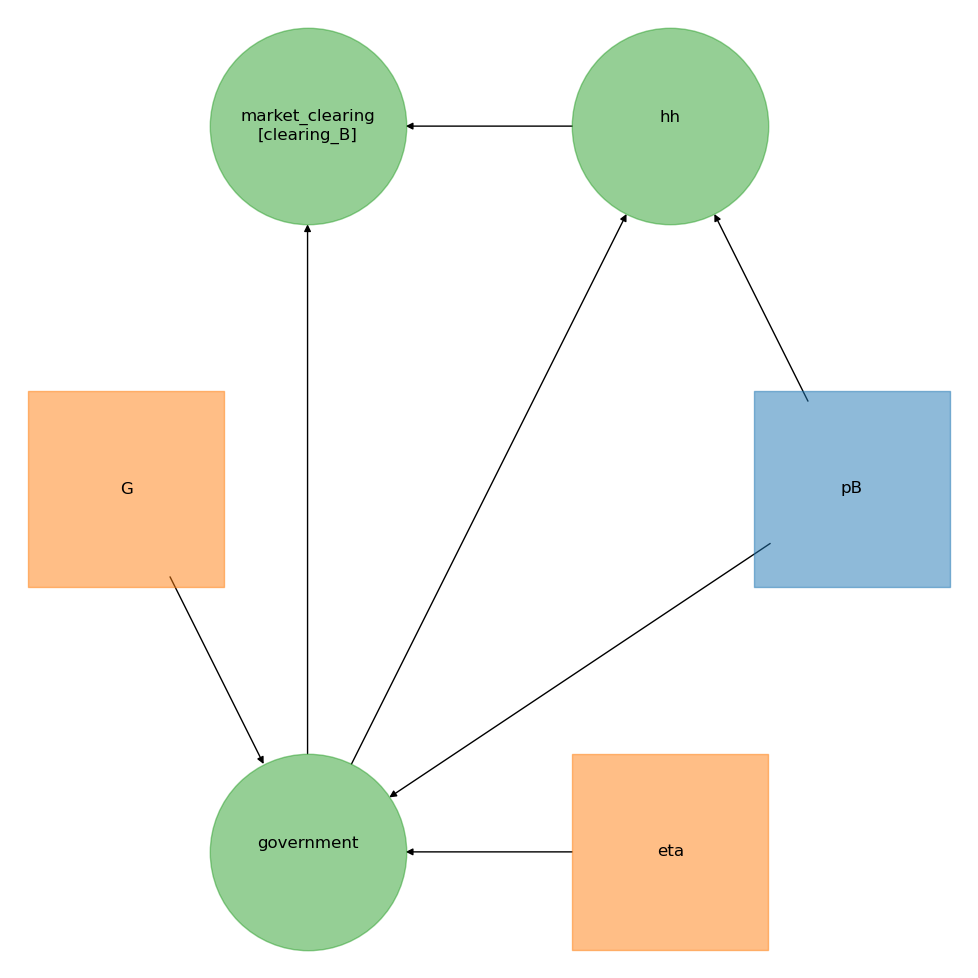

In [12]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

### 4.1. <a id='toc4_1_'></a>[Prepare](#toc0_)

In [13]:
model.find_ss(tau=tau_max_U_hh)

note: inputs = steady state value -> expected: constant value (straigt line) in roughly -10^-5 to 10^5

household problem solved along transition path in 0.7 secs
household problem simulated along transition in 1.3 secs



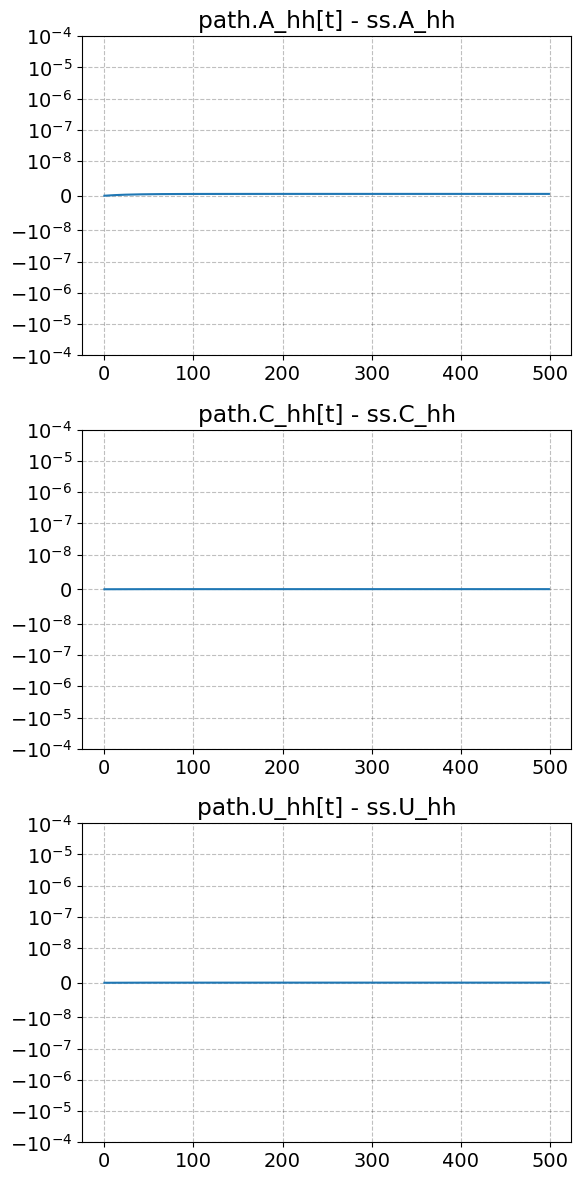

In [14]:
model.test_hh_path()

In [15]:
model.test_path()

shocks: G eta 
unknowns: pB 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.government
  tau              0.0e+00
  B                0.0e+00
 hh
  A_hh             5.3e-10
  C_hh             3.2e-11
  U_hh             3.8e-11
 blocks.market_clearing
  clearing_B       5.3e-10 [target]


**Jacobians:**

In [16]:
model.compute_jacs()

**Higher bond price:** Always less savings due to lower return.

**Higher tax rate:**

1. Lower savings when in effect due to lower income
2. Higher savings when expected due to lower *future* income

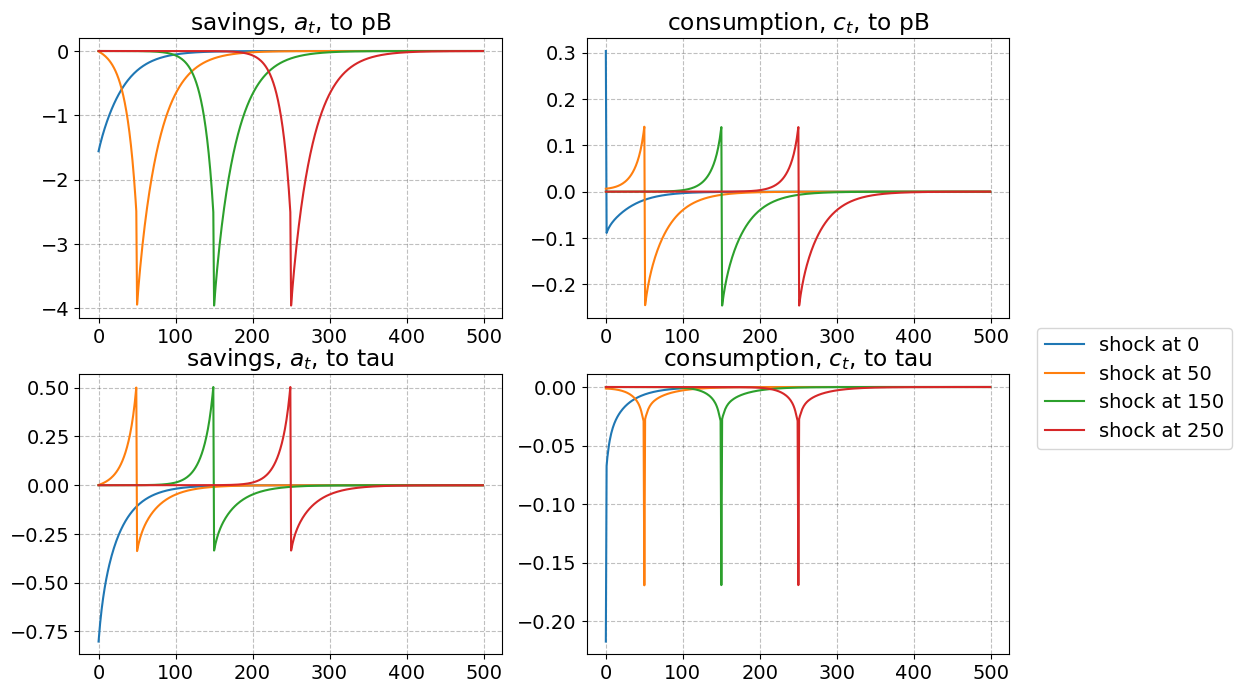

In [17]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

### 4.2. <a id='toc4_2_'></a>[Find transition path](#toc0_)

In [18]:
jump = ss.G*0.01
rho = 0.95
dG = jump*rho**np.arange(par.T)

In [19]:
model.find_transition_path(shocks={'dG':dG},do_print=True)
path = model.path

finding the transition path:
 it =   0 -> max. abs. error = 6.46e-03
 it =   1 -> max. abs. error = 9.46e-06
 it =   2 -> max. abs. error = 3.03e-08
 it =   3 -> max. abs. error = 4.62e-11

transition path found in 2.8 secs


### 4.3. <a id='toc4_3_'></a>[Analyze](#toc0_)

The government issues more bonds. Bond price fall and tax increases. Average utility falls.

### shocks ###


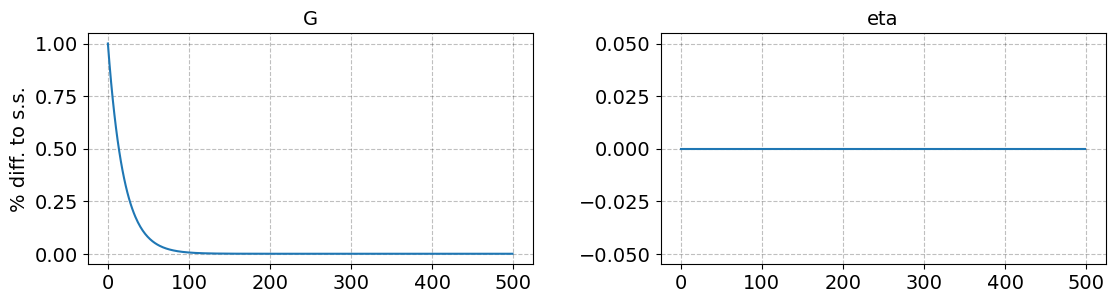


### varnames ###


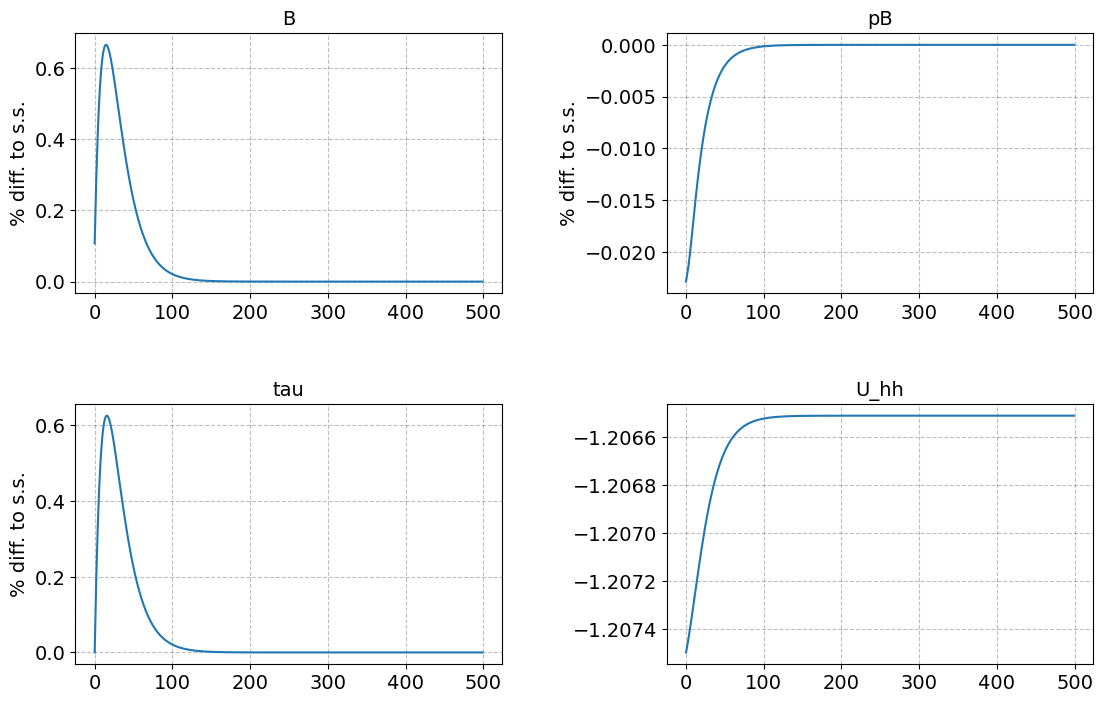


### tagets ###


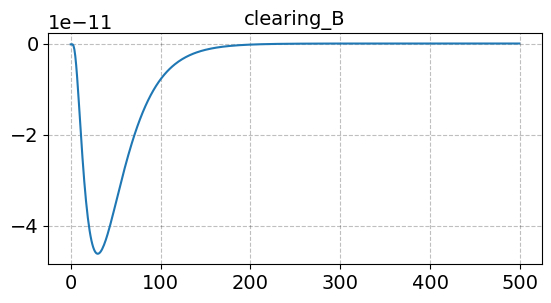

In [20]:
model.show_IRFs(varnames=['B','pB','tau','U_hh'],lvl_value=['U_hh','eta'],ncols=2)

Average expected discounted utility falls:

In [21]:
v_hh_ss = model.v_ss()
v_hh = model.v_path()
print(f'{v_hh_ss = :.5f}')
print(f'{v_hh = :.5f}')

v_hh_ss = -30.16281
v_hh = -30.17726


Initially savings increase both due to taxes (less future income) and higher return (lower bond price). Lower taxes reduce savings.

['tau']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.1 secs

['pB']
household problem solved along transition path in 0.5 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 0.6 secs
household problem simulated along transition in 0.1 secs

all
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs



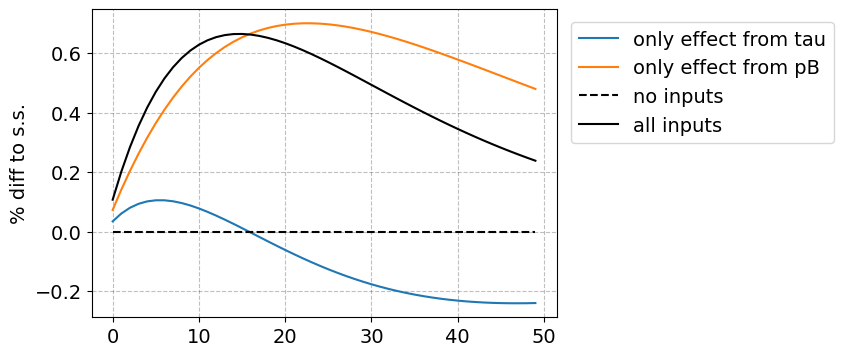

In [22]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['tau'],['pB'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

Consumption inequality decreases. But small effect relative to the lower mean.

In [23]:
mean_c_ss = np.sum(ss.D*ss.c)
std_c_ss = np.sqrt(np.sum(ss.D*(ss.c-mean_c_ss)**2))   

for t in range(20):

    mean_c = np.sum(path.D[t]*path.c[t])
    std_c = np.sqrt(np.sum(path.D[t]*(path.c[t]-mean_c)**2))   

    print(f't = {t:2d}: {mean_c-mean_c_ss:7.4f}, {std_c-std_c_ss:7.4f}')

t =  0: -0.0010, -0.0006
t =  1: -0.0009, -0.0006
t =  2: -0.0009, -0.0005
t =  3: -0.0009, -0.0005
t =  4: -0.0008, -0.0004
t =  5: -0.0008, -0.0004
t =  6: -0.0007, -0.0003
t =  7: -0.0007, -0.0003
t =  8: -0.0007, -0.0003
t =  9: -0.0006, -0.0002
t = 10: -0.0006, -0.0002
t = 11: -0.0006, -0.0002
t = 12: -0.0005, -0.0001
t = 13: -0.0005, -0.0001
t = 14: -0.0005, -0.0001
t = 15: -0.0005, -0.0001
t = 16: -0.0004, -0.0001
t = 17: -0.0004, -0.0000
t = 18: -0.0004, -0.0000
t = 19: -0.0004, -0.0000


## 5. <a id='toc5_'></a>[Extra: Optimal policy](#toc0_)

**Questions:** Will a utiliarian planner always set the tax rate so it maximizes steady state social welfare?

In [24]:
for add in [-0.01,0.01]:

    # a. initial steady state
    model_tau_alt = model.copy()
    model_tau_alt.find_ss(tau=tau_max_U_hh+add)

    # b. transition to new steady state 
    model.find_transition_path(shocks=[],ini=model_tau_alt.ss.__dict__,do_print=False)

    # b. change in expected discounted utility
    def print_v(model,model_tau_alt):

        # steady state    
        v_hh_ss = model_tau_alt.v_ss()
        assert np.isclose(v_hh_ss,1/(1-par.beta)*model_tau_alt.ss.U_hh)

        # allong transition path
        v_hh = model.v_path()

        # difference
        print(f'tau {tau_max_U_hh+add:.3} -> {tau_max_U_hh:.3f}: {v_hh-v_hh_ss = :8.5f}')

    print_v(model,model_tau_alt)

tau 0.119 -> 0.129: v_hh-v_hh_ss =  0.08320
tau 0.139 -> 0.129: v_hh-v_hh_ss = -0.06580


If the initial tax rate is low, the transition is beneficial. Social welfare increases.

If the initial tax rate is high, the transition is not beneficial. Social welfare increase.

**Insight:** Optimal policy needs to account for the transition.

**Question:** Could there be another transition, which makes the policy beneficial?


In [25]:
model_gradual = model.copy()

In [26]:
shocks = {'deta':np.zeros(par.T)}
shocks['deta'][:50] = np.linspace(-0.04,0.0,50)

In [27]:
model_gradual.find_transition_path(shocks=shocks,ini=model_tau_alt.ss.__dict__,do_print=False)
print(f'gradual phase in:')
print_v(model_gradual,model_tau_alt)

gradual phase in:
tau 0.139 -> 0.129: v_hh-v_hh_ss =  0.00205


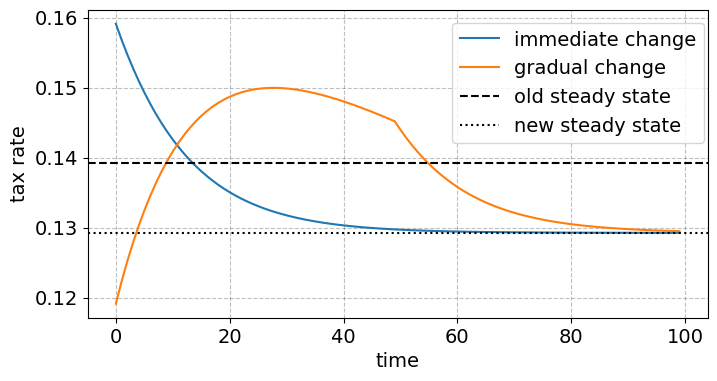

In [28]:
fig = plt.figure(figsize=(8,4),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(model.path.tau[:100],label='immediate change')
ax.plot(model_gradual.path.tau[:100],label='gradual change')

ax.axhline(model_tau_alt.ss.tau,color='black',ls='--',label='old steady state')
ax.axhline(model.ss.tau,color='black',ls=':',label='new steady state')

ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99))
ax.set_xlabel('time')
ax.set_ylabel('tax rate');

**The really complicated question:** What is the optimal path and steady state to converge to? (Ramsey problem)

See e.g. [Optimal Fiscal Policy in a Model with Uninsurable Idiosyncratic Income Risk](https://academic.oup.com/restud/article/90/2/744/6598812).